In [1]:
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [2]:
# reading in training dataset
X_train = pd.read_csv('split_data/X_train.csv')
X_test = pd.read_csv('split_data/X_test.csv')
y_train = pd.read_csv('split_data/y_train.csv')
y_test = pd.read_csv('split_data/y_test.csv')

# Initial Testing

## Linear SVM

In [3]:
linmod = svm.SVC(kernel='linear', C=1e5, gamma=0.1, class_weight='balanced')
linmod.fit(X_train, y_train.values.ravel())

SVC(C=100000.0, class_weight='balanced', gamma=0.1, kernel='linear')

In [4]:
linpreds = linmod.predict(X_test)
print(classification_report(y_test, linpreds, digits=3))

              precision    recall  f1-score   support

           0      0.841     0.841     0.841        63
           1      0.783     0.783     0.783        46

    accuracy                          0.817       109
   macro avg      0.812     0.812     0.812       109
weighted avg      0.817     0.817     0.817       109



## Polynomial SVM

In [5]:
poly = svm.SVC(kernel='poly', C=1e5, gamma=0.1, class_weight='balanced')
poly.fit(X_train, y_train.values.ravel()),

(SVC(C=100000.0, class_weight='balanced', gamma=0.1, kernel='poly'),)

In [6]:
polypreds = poly.predict(X_test)
print(classification_report(y_test, polypreds, digits=3))

              precision    recall  f1-score   support

           0      0.881     0.825     0.852        63
           1      0.780     0.848     0.812        46

    accuracy                          0.835       109
   macro avg      0.831     0.837     0.832       109
weighted avg      0.839     0.835     0.836       109



## RBF Kernel

In [7]:
rbf = svm.SVC(kernel='rbf', C=1e5, gamma=0.1, class_weight='balanced')
rbf.fit(X_train, y_train.values.ravel())

SVC(C=100000.0, class_weight='balanced', gamma=0.1)

In [8]:
rbfpreds = rbf.predict(X_test)
print(classification_report(y_test, rbfpreds, digits=3))

              precision    recall  f1-score   support

           0      0.866     0.921     0.892        63
           1      0.881     0.804     0.841        46

    accuracy                          0.872       109
   macro avg      0.873     0.862     0.867       109
weighted avg      0.872     0.872     0.871       109



## Sigmoid Kernel

In [9]:
sigmoid = svm.SVC(kernel='sigmoid', C=1e5, gamma=0.1, class_weight='balanced')
sigmoid.fit(X_train, y_train.values.ravel())

SVC(C=100000.0, class_weight='balanced', gamma=0.1, kernel='sigmoid')

In [10]:
sigmoidpreds = sigmoid.predict(X_test)
print(classification_report(y_test, sigmoidpreds, digits=3))

              precision    recall  f1-score   support

           0      0.814     0.762     0.787        63
           1      0.700     0.761     0.729        46

    accuracy                          0.761       109
   macro avg      0.757     0.761     0.758       109
weighted avg      0.766     0.761     0.763       109



# Grid Search

In [11]:
def gridsearch(model, grid, X, y):
    grid = GridSearchCV(estimator=model, param_grid=grid, cv=5, verbose=0, n_jobs=-1)
    grid_result = grid.fit(X, y)
    return grid_result

In [12]:
kernel = ['linear', 'poly', 'rbf']
gamma = [1e-1, 1e-2, 1e-3]
C = [1e4, 1e5, 1e6]
params = dict(kernel=kernel, gamma=gamma, C=C)

In [13]:
gridmodel = svm.SVC()
grid_result = gridsearch(gridmodel, params, X_train, y_train.values.ravel())

In [14]:
print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

Best: 0.9429535232383808 using {'C': 10000.0, 'gamma': 0.1, 'kernel': 'rbf'}


# Final Model

In [15]:
frbf = svm.SVC(kernel=grid_result.best_params_['kernel'],
               gamma=grid_result.best_params_['gamma'],
               C=grid_result.best_params_['C'],
               probability=True
              )
frbf.fit(X_train, y_train.values.ravel())

SVC(C=10000.0, gamma=0.1, probability=True)

In [16]:
frbfpreds = frbf.predict(X_test)
print(classification_report(y_test, frbfpreds, digits=3))

              precision    recall  f1-score   support

           0      0.866     0.921     0.892        63
           1      0.881     0.804     0.841        46

    accuracy                          0.872       109
   macro avg      0.873     0.862     0.867       109
weighted avg      0.872     0.872     0.871       109



## Plotting

In [17]:
def make_roc(model, X, y):
    base_fpr = np.linspace(0, 1, 101)
    y_score = model.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    tpr = np.interp(base_fpr, fpr, tpr)
    return tpr, thresholds

In [18]:
base_fpr = np.linspace(0, 1, 101)
ftpr, fthresh = make_roc(frbf, X_test, y_test.values.ravel())
ftprs = np.array(ftpr)
fauc = auc(base_fpr, ftprs)

In [19]:
import matplotlib.pyplot as plt
#matplotlib inline

In [20]:
fcm_rbf = confusion_matrix(y_test, frbfpreds)

In [21]:
from matplotlib.pyplot import GridSpec

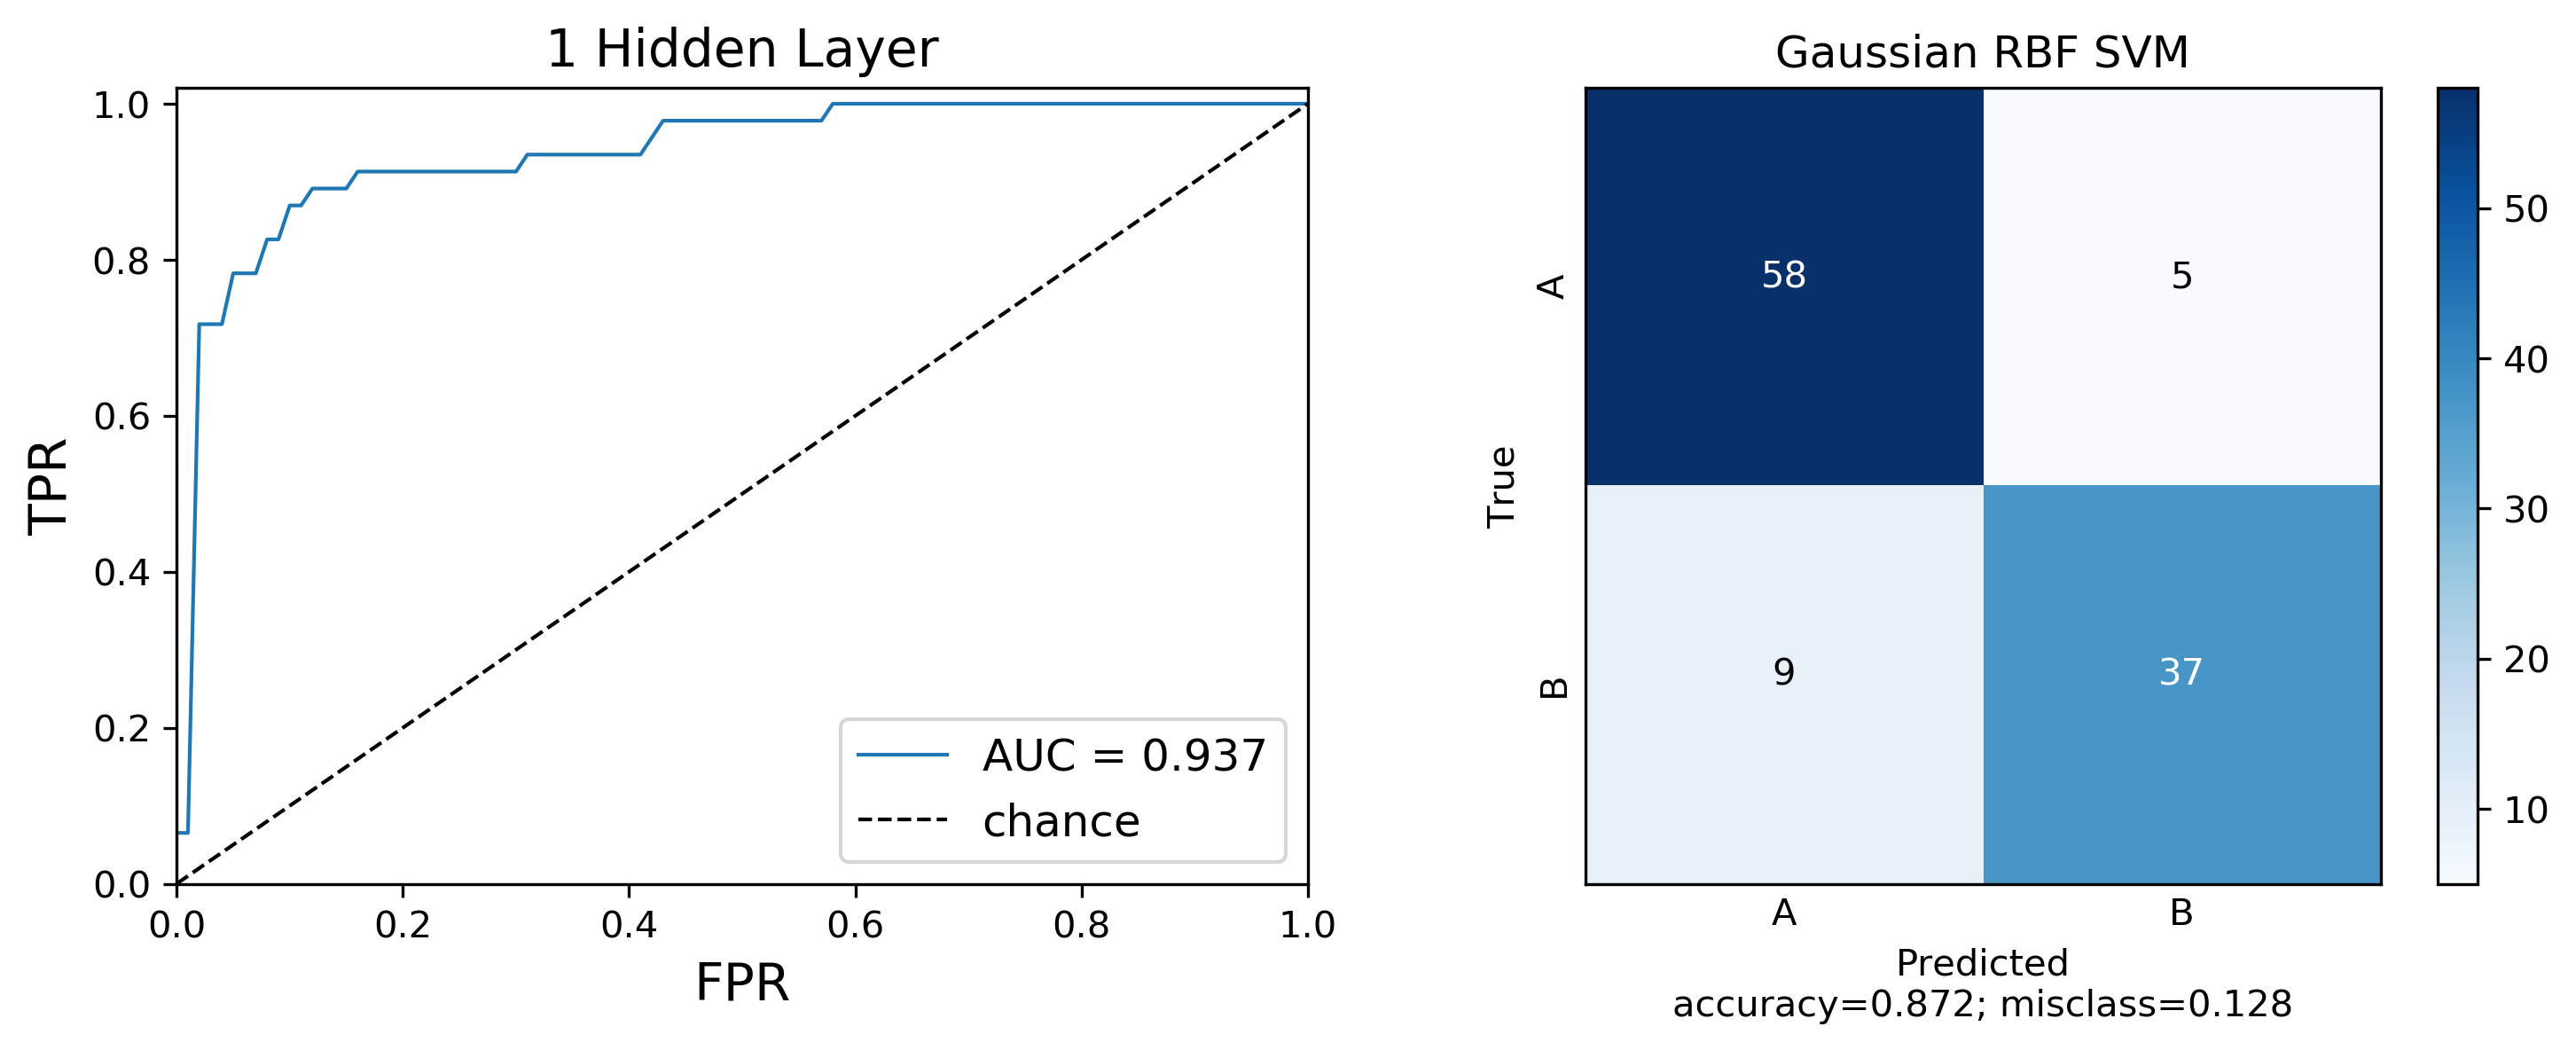

In [22]:
fig = plt.figure(figsize=(10, 4), dpi=300)
spec = GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[0, 0])

# confusion matrix
accuracy = np.trace(fcm_rbf) / np.sum(fcm_rbf)
ax1.set_title('Gaussian RBF SVM')
## setting x and y labels
ax1.set_xlabel('Predicted\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, 1-accuracy))
ax1.set_ylabel('True')
## formatting x and y ticks
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['A', 'B'])
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['A', 'B'], rotation=90)
ax1.tick_params(length=0)
## putting counts in middle of cm square
thresh = fcm_rbf.max() / 2
for i, j in itertools.product(range(fcm_rbf.shape[0]), range(fcm_rbf.shape[1])):
    ax1.text(j, i, '{:,}'.format(fcm_rbf[i, j]),
             horizontalalignment='center',
             color='white' if fcm_rbf[i, j] > thresh else 'black'
            )
## colorbar
im1 = ax1.imshow(fcm_rbf, cmap='Blues')
fig.colorbar(im1, ax=ax1, orientation='vertical')

# ROC
ax2.plot(base_fpr, ftprs, linewidth=1)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.02])
ax2.set_title('1 Hidden Layer', fontsize=14)
ax2.set_ylabel('TPR', fontsize=14)
ax2.set_xlabel('FPR', fontsize=14)
ax2.legend(['AUC = ' + str(round(fauc, 3)), 'chance'], fontsize=12, loc='lower right')

# tight layout
fig.tight_layout()